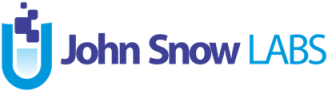

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/llm_notebooks/LangTest_with_DataBricks.ipynb)

# Introduction to LangTest with Databricks Integration

**LangTest** is an open-source Python library designed to help developers deliver safe, robust, and effective Natural Language Processing (NLP) models. In today's rapidly evolving AI landscape, ensuring the quality and reliability of your NLP solutions is critical. LangTest streamlines this process by offering a comprehensive suite of tools to test and validate various NLP models and tasks. Whether you're working with models from **John Snow Labs, Hugging Face, Spacy**, or utilizing cutting-edge large language models (LLMs) from **OpenAI, Cohere, AI21, Hugging Face Inference API, and Azure-OpenAI**, LangTest provides an intuitive and powerful framework for evaluation.

The library supports testing for a diverse range of tasks, including:

- **Named Entity Recognition (NER)**: Evaluate how well your model can identify specific entities, such as names, dates, or locations, in text.
- **Text Classification**: Validate your model's ability to categorize text into predefined labels.
- **Fill-mask**: Test how accurately your model can predict masked words in a sentence.
- **Translation**: Assess the quality of translations produced by your model for various language pairs.

LangTest also shines in its support for LLM-specific tasks, enabling developers to evaluate foundational models for:

- **Question Answering**: Test a model's ability to provide accurate and contextually relevant answers to questions.
- **Visual Question Answering**: Combine image understanding and textual reasoning for multi-modal models.
- **Summarization**: Validate how effectively your model can generate concise summaries of longer texts.
- **Text Generation**: Test the fluency, coherence, and creativity of the text generated by your model.

One of the standout features of LangTest is its comprehensive library of over **100 pre-built tests**, covering everything from data quality checks to bias detection and adversarial robustness testing. These tests help you identify weaknesses and ensure your models perform reliably in real-world scenarios. For a complete list of supported test categories, please visit the [LangTest documentation](http://langtest.org/docs/pages/docs/test_categories).

## Why Integrate LangTest with Databricks?

**Databricks** is a powerful platform for big data analytics and machine learning, offering seamless integration with Apache Spark for distributed computing. By combining LangTest with Databricks, you can scale your model evaluations across large datasets and distributed environments. This integration allows you to:

1. **Efficiently handle large-scale datasets**: Use the parallel processing capabilities of Databricks to run tests on massive datasets without performance bottlenecks.
2. **Collaborate seamlessly**: Databricks' collaborative notebooks make it easy for teams to work together on evaluating and improving NLP models.
3. **Automate testing workflows**: Leverage Databricks' pipeline capabilities to integrate LangTest into your CI/CD workflows for continuous evaluation.

## What Will We Cover in This Tutorial?

In this notebook, we will demonstrate how to use **LangTest** with **Databricks** to test foundational NLP models for the **Question Answering** task using the **MedQA** dataset. The MedQA dataset is specifically designed for evaluating models in the healthcare domain, making it a great benchmark for testing domain-specific question-answering capabilities.

By the end of this tutorial, you will learn how to:

1. Set up LangTest in a Databricks environment.
2. Load and preprocess the MedQA dataset for testing.
3. Configure and run LangTest evaluations for question-answering models.
4. Interpret the results to identify areas for improvement in your models.

Whether you're building state-of-the-art NLP solutions for general applications or tackling domain-specific challenges, this tutorial will equip you with the tools and knowledge to deliver more reliable and impactful models. Let's get started!


### Step 1: Set Up LangTest in a Databricks Environment

To set up **LangTest** in your Databricks environment, follow these steps:

#### 1.1: Launch Databricks Workspace
1. Log in to your **Databricks** account.
2. Navigate to your workspace and open a new or existing notebook.

#### 1.2: Install LangTest
You need to install the **LangTest** library in your Databricks cluster. Use the following commands in a notebook cell to install the library.

In [0]:
%pip install -q langtest[databricks]==2.5.0rc5 # Langtest version >= 2.5.0 is required for databricks support

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
%pip install -q langchain_openai==0.2.5
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


#### 1.3: Verify Installation
To confirm that LangTest is installed correctly, run the following code to check the version of the library:

```bash
!pip show langtest
```

#### 1.4: Set Up Databricks Cluster (Optional)
If you don’t have a cluster running yet:
1. Go to the **Clusters** tab in your Databricks workspace.
2. Click **Create Cluster** and configure it according to your project’s requirements (e.g., Python version, worker nodes).
3. Attach your notebook to the cluster once it's running.

#### 1.5: Import Necessary Libraries
To get started with LangTest, you'll need to import the required libraries in your notebook:


In [0]:
# from langtest import Harness
import os 

os.environ["OPENAI_API_KEY"] = "<YOUR API KEY>"

In [0]:
# %pip show langtest

In [0]:
from langtest import Harness

In [0]:
from pyspark.sql import SparkSession

spark: SparkSession = SparkSession.builder.appName("Langtest").getOrCreate()
spark

### Step 2: Load and Explore the MedQA Dataset

We will now load the **MedQA** dataset, which is specifically designed for question-answering tasks in the medical domain. This dataset includes a set of challenging questions, correct answers, and multiple-choice options.

#### 2.1: Load the MedQA Dataset

The dataset is in JSON Lines format (`.jsonl`), where each line represents a record in JSON format. Use Spark to load it into a DataFrame.


In [0]:
%python
!mkdir -p /dbfs/MedQA/
!curl -o /dbfs/MedQA/test-tiny.jsonl https://raw.githubusercontent.com/JohnSnowLabs/langtest/refs/heads/main/langtest/data/MedQA/test-tiny.jsonl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48418  100 48418    0     0   139k      0 --:--:-- --:--:-- --:--:--  139k


In [0]:
%python
!ls /dbfs/MedQA/

langtest_report  langtest_results  langtest_testcases  test-tiny.jsonl


In [0]:
from pyspark.sql import DataFrame

# Load the dataset into a Spark DataFrame
MedQA_df: DataFrame = spark.read.json("dbfs:/MedQA/test-tiny.jsonl")


#### 2.2: Dataset Overview

The **MedQA** dataset includes the following fields:
- **question**: The medical scenario or problem statement being asked.
- **answer**: The correct answer to the question (e.g., multiple-choice option like "C").
- **options**: The possible answer choices provided for the question.

#### 2.3: Explore the Dataset

Let’s inspect the dataset to confirm its structure and understand its content:

In [0]:
MedQA_df.describe()

DataFrame[summary: string, answer: string, options: string, question: string]

In [0]:
MedQA_df.printSchema()


root
 |-- answer: string (nullable = true)
 |-- options: string (nullable = true)
 |-- question: string (nullable = true)



In [0]:
f"Dataset Count: {MedQA_df.count()}"


'Dataset Count: 50'

In [0]:
MedQA_df.show(5)

+--------------------+--------------------+--------------------+
|              answer|             options|            question|
+--------------------+--------------------+--------------------+
|C. Tell the atten...|A. Disclose the e...|A junior orthopae...|
|E. Cross-linking ...|A. Inhibition of ...|A 67-year-old man...|
|C. Cholesterol em...|A. Renal papillar...|Two weeks after u...|
|D. Lactose-fermen...|A. Coagulase-posi...|A 39-year-old wom...|
|B. Ketotifen eye ...|A. Erythromycin o...|A 35-year-old man...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



#### 2.4: Next Steps

With the dataset loaded and explored, we are now ready to preprocess it (if necessary) and use it with **LangTest** for evaluating the performance of a question-answering model.

### Step 3: Set Up LangTest Harness and Run Test Cases

In this step, we’ll configure the **LangTest** harness to evaluate a question-answering model using the **MedQA** dataset. We'll use a custom test configuration and define specific robustness tests to assess the model's reliability.

#### 3.1: Define the Test Configuration

The test configuration includes the following:
- **Model parameters**: Specifies the temperature and maximum token limit for generating responses.
- **Test types**:
  - **Defaults**: Basic functional tests to ensure the model meets a minimum pass rate.
  - **Robustness**: Tests that simulate common challenges such as typos and text case variations.

Here is the test configuration:

In [0]:
prompt_template = """
You are an AI bot specializing in providing accurate and concise answers to questions. You will be presented with a medical question and multiple-choice answer options. Your task is to choose the correct answer.\nQuestion: {question}\nOptions: {options}\n Answer:
"""

In [0]:
from langtest.types import HarnessConfig

test_config: HarnessConfig = {
    "evaluation": {
        "metric": "llm_eval",
        "model": "gpt-4o", # for evaluation
        "hub": "openai",
    },
    "tests": {
        "defaults": {
            "min_pass_rate": 1.0,
            "user_prompt": prompt_template,
        },
        "robustness": {
            "add_typo": {"min_pass_rate": 0.8},
            "add_ocr_typo": {"min_pass_rate": 0.8},
            "add_speech_to_text_typo":{"min_pass_rate": 0.8},
            "add_slangs": {"min_pass_rate": 0.8},
            "uppercase": {"min_pass_rate": 0.8},
        },
    },
}

In [0]:
input_data = {
    "data_source": MedQA_df,
    "source": "spark",
    "spark_session": spark
}

In [0]:
model_config = {
    "model": {
        # ChatDatabricks or Databricks Class params from the langchain-databricks
        "endpoint": "databricks-meta-llama-3-1-70b-instruct",
        "max_tokens": 20,
    },
    "hub": "databricks",
    "type": "chat"
}

#### 3.2: Set Up the LangTest Harness

Initialize the LangTest harness with the MedQA dataset and the test configuration.

In [0]:
harness = Harness(
    task="question-answering",
    model=model_config,
    data=input_data,
    config=test_config
)

Test Configuration : 
 {
 "evaluation": {
  "metric": "llm_eval",
  "model": "gpt-4o",
  "hub": "openai"
 },
 "tests": {
  "defaults": {
   "min_pass_rate": 1.0,
   "user_prompt": "\nYou are an AI bot specializing in providing accurate and concise answers to questions. You will be presented with a medical question and multiple-choice answer options. Your task is to choose the correct answer.\nQuestion: {question}\nOptions: {options}\n Answer:\n"
  },
  "robustness": {
   "add_typo": {
    "min_pass_rate": 0.8
   },
   "add_ocr_typo": {
    "min_pass_rate": 0.8
   },
   "add_speech_to_text_typo": {
    "min_pass_rate": 0.8
   },
   "add_slangs": {
    "min_pass_rate": 0.8
   },
   "uppercase": {
    "min_pass_rate": 0.8
   }
  }
 }
}


In [0]:
harness.data = harness.data[:1]

In [0]:
harness.generate()

Generating testcases...: 100%|██████████| 1/1 [00:00<00:00, 9619.96it/s]
- Test 'add_typo': 3 samples removed out of 50
- Test 'add_slangs': 2 samples removed out of 50



In [0]:
testcases = harness.testcases()
testcases

,category,test_type,original_question,perturbed_question,options
0,robustness,add_typo,A junior orthopaedic surgery resident is compl...,A junior orthopaedic surgery residsnt is compl...,A. Disclose the error to the patient but leave...
1,robustness,add_typo,A 67-year-old man with transitional cell carci...,A 67-year-old man with transitional cell carci...,A. Inhibition of thymidine synthesis\nB. Inhib...
2,robustness,add_typo,Two weeks after undergoing an emergency cardia...,Two weeks after undergoing an emergency cardia...,A. Renal papillary necrosis\nB. Allergic inter...
3,robustness,add_typo,A 39-year-old woman is brought to the emergenc...,A 39-year-old woman is brought to the emergenc...,"A. Coagulase-positive, gram-positive cocci for..."
4,robustness,add_typo,A 35-year-old man comes to the physician becau...,A 35-year-old man comes to the physician becau...,A. Erythromycin ointment\nB. Ketotifen eye dro...
...,...,...,...,...,...
240,robustness,uppercase,A man is brought into the emergency department...,A MAN IS BROUGHT INTO THE EMERGENCY DEPARTMENT...,A. Ethanol\nB. Naltrexone\nC. Naloxone\nD. Flu...
241,robustness,uppercase,A medical research study is evaluating an inve...,A MEDICAL RESEARCH STUDY IS EVALUATING AN INVE...,A. 5\nB. 16\nC. 20\nD. 30\nE. 50
242,robustness,uppercase,A 55-year-old man comes to the physician becau...,A 55-YEAR-OLD MAN COMES TO THE PHYSICIAN BECAU...,A. Femoropopliteal artery stenosis\nB. Vasculi...
243,robustness,uppercase,A 29-year-old primigravid woman at 35 weeks' g...,A 29-YEAR-OLD PRIMIGRAVID WOMAN AT 35 WEEKS' G...,A. Perform karyotyping of amniotic fluid\nB. R...


In [0]:
testcases_dlt_df = spark.createDataFrame(testcases)

testcases_dlt_df.write.format("delta").mode("overwrite").save("dbfs:/MedQA/langtest_testcases")

#### 3.3: Run the Test Cases

Run the tests defined in the configuration. The output will include test results for each test case and their respective pass/fail status.

In [0]:
harness.run()

Running testcases... :   0%|          | 0/245 [00:00<?, ?it/s]/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/langtest/modelhandler/llm_modelhandler.py:194: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llmchain = LLMChain(prompt=prompt_template, llm=self.model)
Running testcases... : 100%|██████████| 245/245 [07:08<00:00,  1.16s/it]

#### 3.4: Analyze the Results

The output will include:
- **Defaults**: Results showing whether the model passed the basic functional tests.
- **Robustness**:
  - **add_typo**: Evaluates the model’s ability to handle typos in input text.
  - **lowercase**: Tests the model’s performance with all input text converted to lowercase.


In [0]:
generated_results = harness.generated_results()
generated_results

Running testcases... : 100%|██████████| 245/245 [10:35<00:00,  2.59s/it]


,category,test_type,original_question,perturbed_question,options,expected_result,actual_result,pass
0,robustness,add_typo,A junior orthopaedic surgery resident is compl...,A junior orthopaedic surgery residsnt is compl...,A. Disclose the error to the patient but leave...,The correct answer is B. Disclose the error to...,The correct answer is B. Disclose the error to...,True
1,robustness,add_typo,A 67-year-old man with transitional cell carci...,A 67-year-old man with transitional cell carci...,A. Inhibition of thymidine synthesis\nB. Inhib...,"To solve this question, let's break it down st...","To solve this question, let's break it down st...",True
2,robustness,add_typo,Two weeks after undergoing an emergency cardia...,Two weeks after undergoing an emergency cardia...,A. Renal papillary necrosis\nB. Allergic inter...,To determine the most likely cause of this pat...,To determine the most likely cause of this pat...,True
3,robustness,add_typo,A 39-year-old woman is brought to the emergenc...,A 39-year-old woman is brought to the emergenc...,"A. Coagulase-positive, gram-positive cocci for...","To solve this question, let's break down the k...","To solve this question, let's break down the k...",True
4,robustness,add_typo,A 35-year-old man comes to the physician becau...,A 35-year-old man comes to the physician becau...,A. Erythromycin ointment\nB. Ketotifen eye dro...,"To determine the most appropriate treatment, l...","To determine the most appropriate treatment, l...",True
...,...,...,...,...,...,...,...,...
240,robustness,uppercase,A man is brought into the emergency department...,A MAN IS BROUGHT INTO THE EMERGENCY DEPARTMENT...,A. Ethanol\nB. Naltrexone\nC. Naloxone\nD. Flu...,"To address this patient's condition, let's bre...","To address this patient's condition, we need t...",False
241,robustness,uppercase,A medical research study is evaluating an inve...,A MEDICAL RESEARCH STUDY IS EVALUATING AN INVE...,A. 5\nB. 16\nC. 20\nD. 30\nE. 50,To calculate the Number Needed to Treat (NNT) ...,To calculate the Number Needed to Treat (NNT) ...,True
242,robustness,uppercase,A 55-year-old man comes to the physician becau...,A 55-YEAR-OLD MAN COMES TO THE PHYSICIAN BECAU...,A. Femoropopliteal artery stenosis\nB. Vasculi...,The correct answer is A. Femoropopliteal arter...,The correct answer is A. Femoropopliteal arter...,True
243,robustness,uppercase,A 29-year-old primigravid woman at 35 weeks' g...,A 29-YEAR-OLD PRIMIGRAVID WOMAN AT 35 WEEKS' G...,A. Perform karyotyping of amniotic fluid\nB. R...,The correct answer is B. Recommend autopsy of ...,The correct answer is B. Recommend autopsy of ...,True


In [0]:
results_dlt_df = spark.createDataFrame(generated_results)

results_dlt_df.write.format("delta").mode("overwrite").save("dbfs:/MedQA/langtest_results")

In [0]:
report = harness.report()
report

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,add_typo,14,33,70%,80%,False
1,robustness,add_ocr_typo,22,28,56%,80%,False
2,robustness,add_speech_to_text_typo,9,41,82%,80%,True
3,robustness,add_slangs,22,26,54%,80%,False
4,robustness,uppercase,19,31,62%,80%,False


In [0]:
report_dlt_df = spark.createDataFrame(report)

report_dlt_df.write.format("delta").mode("overwrite").save("dbfs:/MedQA/langtest_report")